In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

from pathlib import Path
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pathlib import Path
from pymatgen.core import Structure, Composition, Element

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# see https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
import torch
torch.set_float32_matmul_precision('high')

### Load data

In [2]:
qc_ac_te_mp_dataset = pd.read_pickle('../data/raw/qc_ac_te_mp_rebuild_T=290K_20250202.pd.xz')

qc_ac_te_mp_dataset.head(3)
qc_ac_te_mp_dataset.shape

,formula,hypermaterial_type,temperature,composition,elements,Thermal conductivity,Seebeck coefficient,Carrier concentration,Electrical conductivity,Thermopower,...,Density,Efermi,Final energy per atom,Formation energy per atom,Total magnetization,Volume,Magnetic susceptibility,Hall coefficient,Electronic contribution,Electronic thermal conductivity
id,,,,,,,,,,,,,,,,,,,,,
starry_0,(ErAs)0.003InGaAs,others,290,"(Er, As, In, Ga)","(Er, As, In, Ga)",3.2670491071158483,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qa_1,Al61.5Cu26.5Fe12,IQC,290,"(Al, Cu, Fe)","(Al, Cu, Fe)",1.4258964578008275,-1.1863527516689362e-05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starry_2,Bi2Te2.4Se0.6,others,290,"(Bi, Te, Se)","(Bi, Te, Se)",NaN,NaN,-5.436073908332581e+24,1063.8779641515926,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(41017, 26)

All properties

In [3]:
starry_props = [
    "Thermal conductivity",
    "Carrier concentration",
    "Electrical conductivity",
    "Thermopower",
    "Electrical resistivity",
    "Power factor",
    "Seebeck coefficient",
    "Lattice thermal conductivity",
    "ZT",
    "Hall mobility",
    "Electronic contribution",  # Nan after QuantileTransformer
    "Electronic thermal conductivity",
]

ac_qc_props = [
    "Seebeck coefficient",
    "Thermal conductivity",
    "Electrical resistivity",
    "Magnetic susceptibility",
    # "Specific heat capacity",
    "Hall coefficient",
    "ZT",
    "Power factor",
]

mp_props = [
    "Band gap",
    "Density",
    "Efermi",
    "Final energy per atom",
    "Formation energy per atom",
    "Total magnetization",
    "Volume",  
]

ac_qc_starry_shared_props = [
    "Seebeck coefficient",
    "Thermal conductivity",
    "Electrical resistivity",
    "Power factor",
    "ZT",
]

ac_qc_starry_props = [
    "Seebeck coefficient",
    "Thermal conductivity",
    "Electrical resistivity",
    "Magnetic susceptibility",
    # "Specific heat capacity",
    "Hall coefficient",
    "ZT",
    "Power factor",
    "Carrier concentration",
    "Electrical conductivity",
    "Thermopower",
    "Lattice thermal conductivity",
    "Hall mobility",
    "Electronic contribution",
    "Electronic thermal conductivity",
]

all_props = ac_qc_starry_props + mp_props

qc_ac_te_mp_props = qc_ac_te_mp_dataset[all_props]

Calculate descriptors

In [4]:
from xenonpy.descriptor import Compositions
from sklearn.preprocessing import MinMaxScaler, StandardScaler

featurizers = ['WeightedAverage', 'WeightedVariance', 'MaxPooling', 'MinPooling']
comp_calc = Compositions(featurizers=featurizers, n_jobs=20)  # use specific featurizers

In [5]:
all_comp_desc = comp_calc.fit_transform(qc_ac_te_mp_dataset).dropna()
qc_ac_te_mp_props = qc_ac_te_mp_props.loc[all_comp_desc.index]

all_comp_desc.shape
all_comp_desc.head(3)

(40975, 232)

,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
id,,,,,,,,,,,,,,,,,,,,,
starry_0,37.692282,148.686294,236.696274,13.537758,86.556599,1968.408516,61.147068,454.500998,127.719228,129.027944,...,2.0,4.0,0.168,15.00,185.0,188.0,236.0,339.1,1215.0,4.31
qa_1,18.800000,136.985000,231.610000,8.883500,40.134736,2800.460000,104.240000,455.520000,126.435000,121.090000,...,1.0,3.0,0.385,80.00,184.0,225.0,223.0,291.2,3570.0,6.20
starry_2,62.240000,161.600000,243.040000,20.340000,154.316680,1474.412000,44.596000,459.240000,139.840000,139.600000,...,2.0,4.0,0.124,0.52,190.0,182.0,229.0,420.5,1790.0,3.77


Data transform to get normalized data

In [6]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal').set_output(transform="pandas")

qc_ac_te_mp_props = qt.fit_transform(qc_ac_te_mp_props)

joblib.dump(qt, '../data/qc_ac_te_mp_quantile_transformer.pkl.z', protocol=5)
qc_ac_te_mp_props.shape
qc_ac_te_mp_props.head(3)
qc_ac_te_mp_props.isna().all(axis=0)

['../data/qc_ac_te_mp_quantile_transformer.pkl.z']

(40975, 21)

,Seebeck coefficient,Thermal conductivity,Electrical resistivity,Magnetic susceptibility,Hall coefficient,ZT,Power factor,Carrier concentration,Electrical conductivity,Thermopower,...,Hall mobility,Electronic contribution,Electronic thermal conductivity,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,Total magnetization,Volume
id,,,,,,,,,,,,,,,,,,,,,
starry_0,NaN,0.022260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qa_1,-0.390044,-0.749677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starry_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.033656,-0.916678,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Seebeck coefficient                False
Thermal conductivity               False
Electrical resistivity             False
Magnetic susceptibility            False
Hall coefficient                   False
ZT                                 False
Power factor                       False
Carrier concentration              False
Electrical conductivity            False
Thermopower                        False
Lattice thermal conductivity       False
Hall mobility                      False
Electronic contribution            False
Electronic thermal conductivity    False
Band gap                           False
Density                            False
Efermi                             False
Final energy per atom              False
Formation energy per atom          False
Total magnetization                False
Volume                             False
dtype: bool

----

## NN model

In [7]:
used_props = qc_ac_te_mp_props[all_props].dropna(how='all')
used_desc = all_comp_desc.loc[used_props.index]

In [8]:
from foundation_model.configs.model_config import ExperimentConfig, ModelConfig
from foundation_model.data.datamodule import CompoundDataModule
from foundation_model.data.preprocessor import AttributePreprocessor
from foundation_model.data.splitter import MultiTaskSplitter
from foundation_model.models.multi_task import MultiTaskAttributePredictor
from foundation_model.utils.training import training

In [9]:
# Prepare datasets
property_fractions = {
    'Seebeck coefficient': 1.,
    'Thermal conductivity': 0.1,
    'Electrical resistivity': 0.1,
    'Magnetic susceptibility': 1.,
    # 'Specific heat capacity': 1.,
    'Electrical conductivity': 1.,
    'ZT': 1.,
    'Hall coefficient': 1.,
    'Power factor': 1.,
    'Carrier concentration': 1.,
    'Thermopower': 1.,
    'Lattice thermal conductivity': 1.,
    'Hall mobility': 1.,
    'Electronic contribution': 1.,
    'Electronic thermal conductivity': 1.,
    'Band gap': .0,
    'Density': .0,
    'Efermi': .0,
    'Final energy per atom': .0,
    'Formation energy per atom': .0,
    'Total magnetization': .0,
    'Volume': .0
}

In [10]:
preprocessor = AttributePreprocessor(attribute_rates=property_fractions)
processed_attrs = preprocessor.process(used_props)

In [11]:
splitter = MultiTaskSplitter(
    train_ratio=0.8, val_ratio=0.2, test_ratio=0.0, random_state=42
)

In [12]:
train_idx, val_idx, _ = splitter.split(processed_attrs)

In [13]:
datamodule = CompoundDataModule(
    descriptor=used_desc,
    attributes=processed_attrs,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=128,
    num_workers=0,
)

In [14]:
# Initialize model
shared_block_dims = [used_desc.shape[1], 128, 64]
task_block_dims = [64, 32, 16, 1]
model = MultiTaskAttributePredictor(
    shared_block_dims=shared_block_dims,
    task_block_dims=task_block_dims,
    n_tasks=len(processed_attrs.columns),
    norm_shared=True,
    norm_tasks=True,
    residual_shared=True,
    residual_tasks=True,
    shared_block_lr=0.001,
    task_block_lr=0.01
)
# model
# model = torch.compile(model)

In [15]:
trainer = training(
    model=model,
    datamodule=datamodule,
    max_epochs=500,
    accelerator='cpu',
    devices=1,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name          | Type        | Params | Mode 
------------------------------------------------------
0 | shard_block   | LinearBlock | 80.6 K | train
1 | deposit_layer | Sequential  | 4.2 K  | train
2 | task_blocks   | ModuleList  | 78.0 K | train
------------------------------------------------------
162 K     Trainable params
0         Non-trainable params
162 K     Total params
0.651     Total estimated model params size (MB)
438   

Sanity Checking: |                                                                                    | 0/? [0…

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/loops/fit

Training: |                                                                                           | 0/? [0…

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 66. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |                                                                                         | 0/? [0…

/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 42. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 1.170
Epoch 0, global step 76: 'val_loss' reached 1.17029 (best 1.17029), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=00-val_loss=1.1703.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.038 >= min_delta = 0.0001. New best score: 1.132
Epoch 1, global step 152: 'val_loss' reached 1.13229 (best 1.13229), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=01-val_loss=1.1323.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.024 >= min_delta = 0.0001. New best score: 1.108
Epoch 2, global step 228: 'val_loss' reached 1.10826 (best 1.10826), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=02-val_loss=1.1083.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.018 >= min_delta = 0.0001. New best score: 1.090
Epoch 3, global step 304: 'val_loss' reached 1.09027 (best 1.09027), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=03-val_loss=1.0903.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 1.086
Epoch 4, global step 380: 'val_loss' reached 1.08552 (best 1.08552), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=04-val_loss=1.0855.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 1.079
Epoch 5, global step 456: 'val_loss' reached 1.07913 (best 1.07913), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=05-val_loss=1.0791.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 1.067
Epoch 6, global step 532: 'val_loss' reached 1.06684 (best 1.06684), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=06-val_loss=1.0668.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 1.055
Epoch 7, global step 608: 'val_loss' reached 1.05545 (best 1.05545), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=07-val_loss=1.0554.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 1.052
Epoch 8, global step 684: 'val_loss' reached 1.05191 (best 1.05191), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=08-val_loss=1.0519.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 1.047
Epoch 9, global step 760: 'val_loss' reached 1.04708 (best 1.04708), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=09-val_loss=1.0471.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 1.040
Epoch 10, global step 836: 'val_loss' reached 1.04004 (best 1.04004), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=10-val_loss=1.0400.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 1.031
Epoch 11, global step 912: 'val_loss' reached 1.03057 (best 1.03057), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=11-val_loss=1.0306.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 1.023
Epoch 12, global step 988: 'val_loss' reached 1.02326 (best 1.02326), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=12-val_loss=1.0233.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 13, global step 1064: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 14, global step 1140: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 1.011
Epoch 15, global step 1216: 'val_loss' reached 1.01113 (best 1.01113), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=15-val_loss=1.0111.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 1.003
Epoch 16, global step 1292: 'val_loss' reached 1.00278 (best 1.00278), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=16-val_loss=1.0028.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 17, global step 1368: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.991
Epoch 18, global step 1444: 'val_loss' reached 0.99127 (best 0.99127), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=18-val_loss=0.9913.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.991
Epoch 19, global step 1520: 'val_loss' reached 0.99078 (best 0.99078), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=19-val_loss=0.9908.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 20, global step 1596: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.983
Epoch 21, global step 1672: 'val_loss' reached 0.98299 (best 0.98299), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=21-val_loss=0.9830.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 22, global step 1748: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.974
Epoch 23, global step 1824: 'val_loss' reached 0.97355 (best 0.97355), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=23-val_loss=0.9735.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 24, global step 1900: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.972
Epoch 25, global step 1976: 'val_loss' reached 0.97193 (best 0.97193), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=25-val_loss=0.9719.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 26, global step 2052: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 27, global step 2128: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 28, global step 2204: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.015 >= min_delta = 0.0001. New best score: 0.957
Epoch 29, global step 2280: 'val_loss' reached 0.95729 (best 0.95729), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=29-val_loss=0.9573.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 30, global step 2356: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.954
Epoch 31, global step 2432: 'val_loss' reached 0.95441 (best 0.95441), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=31-val_loss=0.9544.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 32, global step 2508: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.945
Epoch 33, global step 2584: 'val_loss' reached 0.94536 (best 0.94536), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=33-val_loss=0.9454.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 34, global step 2660: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 35, global step 2736: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 36, global step 2812: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 37, global step 2888: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 38, global step 2964: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 39, global step 3040: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 40, global step 3116: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.943
Epoch 41, global step 3192: 'val_loss' reached 0.94319 (best 0.94319), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=41-val_loss=0.9432.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 42, global step 3268: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 43, global step 3344: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 44, global step 3420: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 45, global step 3496: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 46, global step 3572: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.938
Epoch 47, global step 3648: 'val_loss' reached 0.93844 (best 0.93844), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=47-val_loss=0.9384.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 48, global step 3724: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 49, global step 3800: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.933
Epoch 50, global step 3876: 'val_loss' reached 0.93333 (best 0.93333), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=50-val_loss=0.9333.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 51, global step 3952: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 52, global step 4028: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.926
Epoch 53, global step 4104: 'val_loss' reached 0.92611 (best 0.92611), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=53-val_loss=0.9261.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 54, global step 4180: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 55, global step 4256: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 56, global step 4332: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 57, global step 4408: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.924
Epoch 58, global step 4484: 'val_loss' reached 0.92398 (best 0.92398), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=58-val_loss=0.9240.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 59, global step 4560: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.914
Epoch 60, global step 4636: 'val_loss' reached 0.91357 (best 0.91357), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=60-val_loss=0.9136.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 61, global step 4712: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 62, global step 4788: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 63, global step 4864: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 64, global step 4940: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 65, global step 5016: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 66, global step 5092: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 67, global step 5168: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.907
Epoch 68, global step 5244: 'val_loss' reached 0.90669 (best 0.90669), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=68-val_loss=0.9067.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 69, global step 5320: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 70, global step 5396: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 71, global step 5472: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 72, global step 5548: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 73, global step 5624: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 74, global step 5700: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 75, global step 5776: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 76, global step 5852: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Metric val_loss improved by 0.015 >= min_delta = 0.0001. New best score: 0.892
Epoch 77, global step 5928: 'val_loss' reached 0.89209 (best 0.89209), saving model to 'lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=77-val_loss=0.8921.ckpt' as top 1


Validation: |                                                                                         | 0/? [0…

Epoch 78, global step 6004: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 79, global step 6080: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 80, global step 6156: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 81, global step 6232: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 82, global step 6308: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 83, global step 6384: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 84, global step 6460: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 85, global step 6536: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Epoch 86, global step 6612: 'val_loss' was not in top 1


Validation: |                                                                                         | 0/? [0…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.892. Signaling Trainer to stop.
Epoch 87, global step 6688: 'val_loss' was not in top 1
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=77-val_loss=0.8921.ckpt
Loaded model weights from the checkpoint at lightning_logs/common_logs/my_exp_name/version_0/checkpoints/model-epoch=77-val_loss=0.8921.ckpt
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not

In [27]:
predictions = trainer.predict(model=model, dataloaders=datamodule.val_dataloader())

Predicting: |                                                                                         | 0/? [0…

In [43]:
all_preds = []
all_targets = []
all_masks = []

for part in predictions:
    preds, targets, masks, _ = part.values()
    all_preds.append(preds)
    all_targets.append(targets)
    all_masks.append(masks)

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
all_masks = np.concatenate(all_masks)

In [38]:
from foundation_model.utils.plotting import plot_predictions

ValueError: Cannot calculate a linear regression if all x values are identical

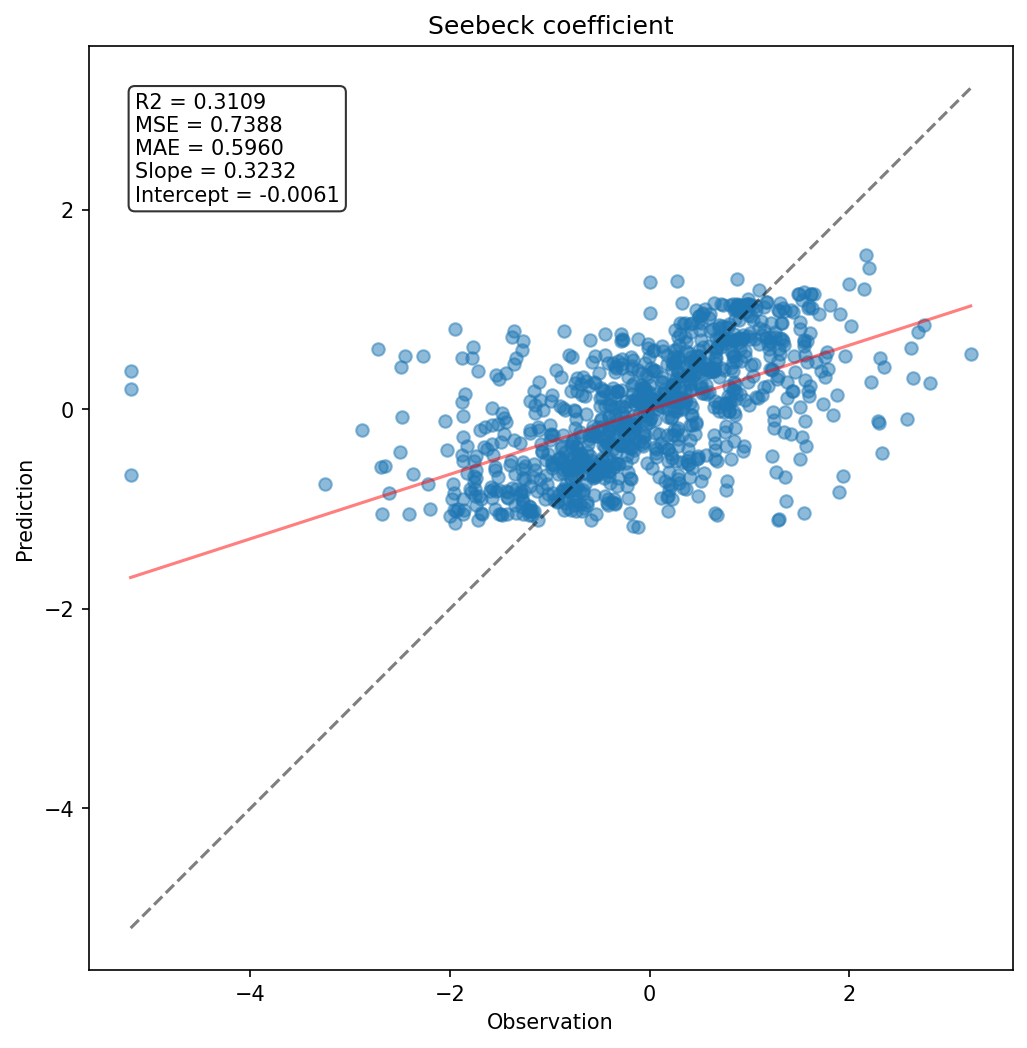

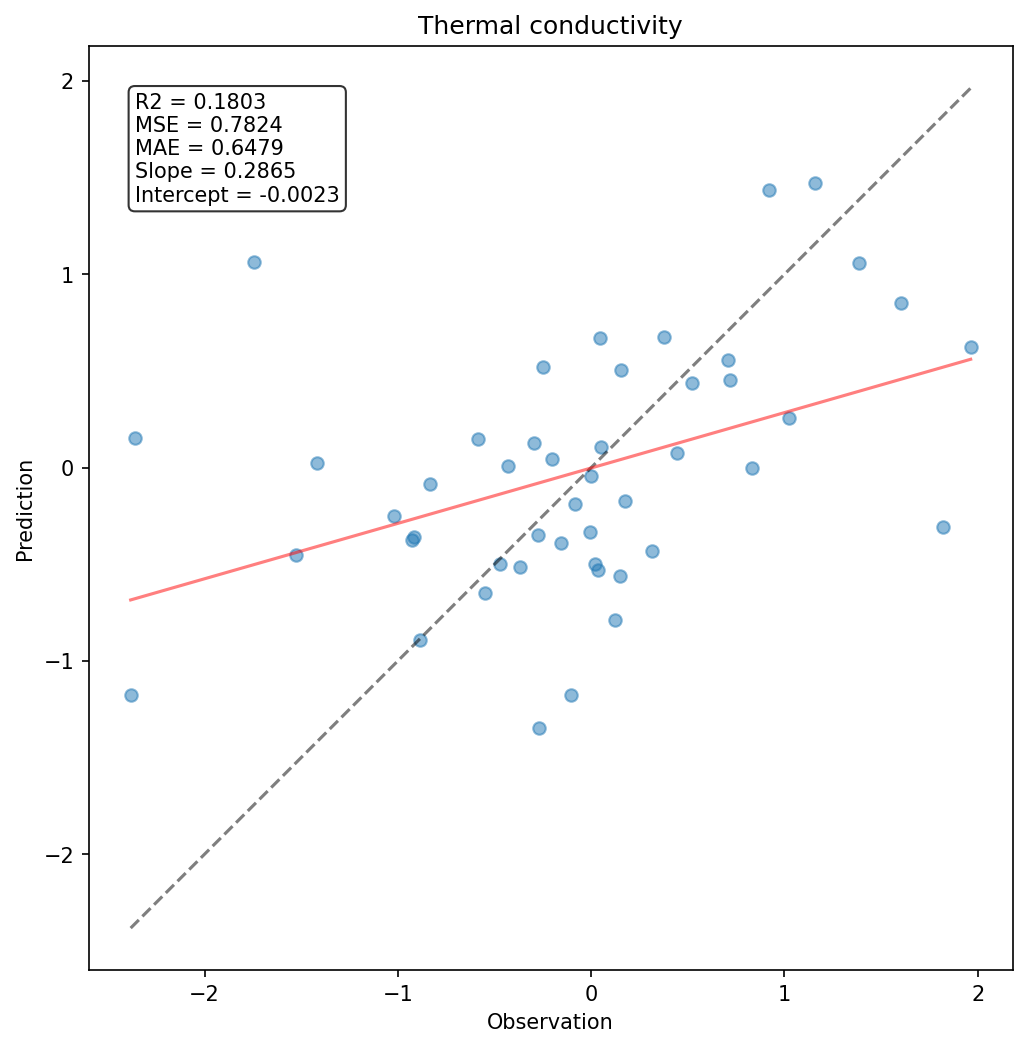

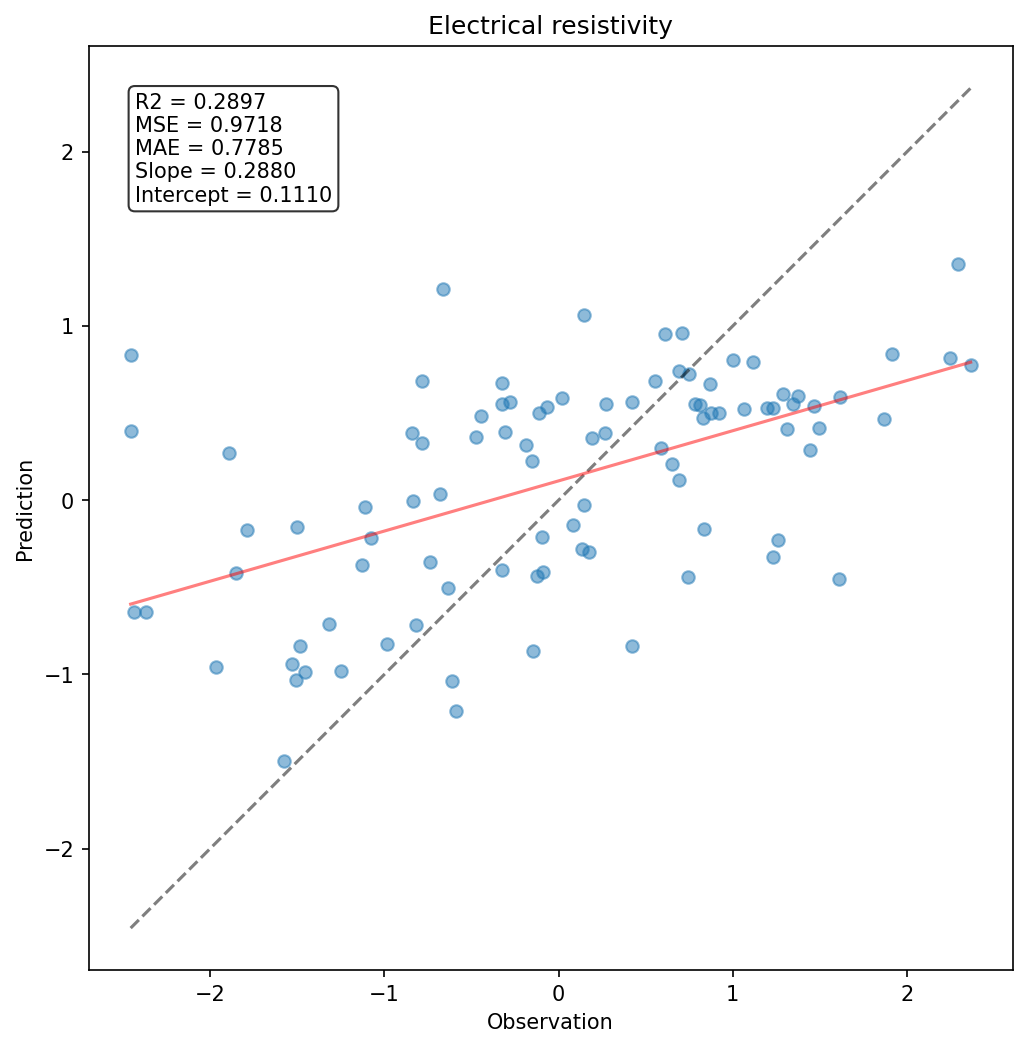

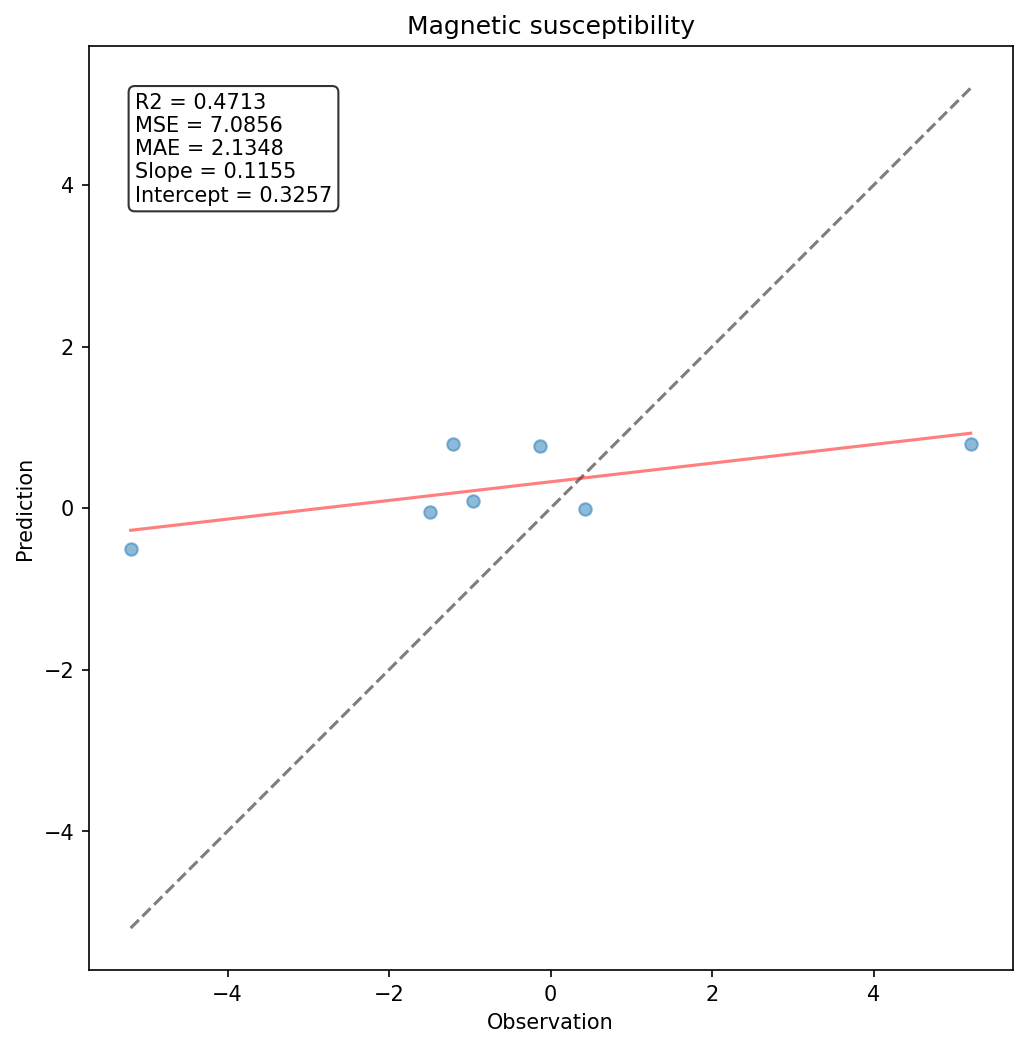

In [44]:
attributes = processed_attrs.columns
plot_predictions(all_preds, all_targets, all_masks, attributes=attributes, savefig='images/multi_tasks/', suffix='all_qc_ac_te_data', return_stat=True)

---------

In [ ]:
%run multi_task.py
%run plot_utils.py

In [22]:
from typing import Optional, Dict, List, Tuple
import torch
import pandas as pd
from pathlib import Path
# from multi_task import scaling_laws_test, CompoundDataset

def test_all_properties(
    descriptor_df: pd.DataFrame,
    property_df: pd.DataFrame,
    device: str = 'cuda'
) -> Dict[str, Dict[str, Tuple[List[float], List[float], List[float]]]]:
    """
    Test scaling laws for all properties in both vary_target and vary_others modes.
    
    Args:
        descriptor_df: DataFrame containing input features
        property_df: DataFrame containing property values
        device: Device to run the model on ('cpu' or 'cuda')
    
    Returns:
        Dict with structure:
        {
            property_name: {
                'vary_target': (test_losses, test_losses_std, fractions),
                'vary_others': (test_losses, test_losses_std, fractions)
            }
        }
        where:
        - test_losses: List of mean test losses for each fraction
        - test_losses_std: List of standard deviations of test losses
        - fractions: List of data fractions used
    """
    results: Dict[str, Dict[str, Tuple[List[float], List[float], List[float]]]] = {}
    
    # Create results directory
    results_dir = Path('images/multi_tasks/scaling_laws')
    results_dir.mkdir(parents=True, exist_ok=True)
    
    # Test each property
    for property_name in CompoundDataset.ATTRIBUTES:
        if property_name != 'seebeck_coefficient':
            continue
        results[property_name] = {}
        print(f"\n{'='*80}")
        print(f"Testing scaling laws for {property_name}")
        print(f"{'='*80}")
        
        # Test vary_target mode
        print(f"\nMode: vary_target (varying {property_name} data while fixing others)")
        results[property_name]['vary_target'] = scaling_laws_test(
            descriptor=descriptor_df,
            property_data=property_df,
            target_property=property_name,
            mode='vary_target',
            device=device
        )
        
        # # Test vary_others mode
        # print(f"\nMode: vary_others (fixing {property_name} while varying others)")
        # results[property_name]['vary_others'] = scaling_laws_test(
        #     descriptor=descriptor_df,
        #     property_data=property_df,
        #     target_property=property_name,
        #     mode='vary_others',
        #     device=device
        # )

    return results

In [23]:
if __name__ == '__main__':
    # Example usage
    
    # Check for CUDA availability
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Run tests
    scaling_results = test_all_properties(used_props, used_props, device=device)

Epoch [91/100], Training Loss: 4.2651

Test Losses by Attribute:
electrical_resistivity: 9.7488
thermal_conductivity: 0.8889
seebeck_coefficient: 2.3087
power_factor: 3.9028
zt: 3.6565
hall_coefficient: 10.2821
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)
Epoch [1/100], Training Loss: 17.2831
Epoch [11/100], Training Loss: 9.2160
Epoch [21/100], Training Loss: 7.2978
Epoch [31/100], Training Loss: 6.1254
Epoch [41/100], Training Loss: 5.4639
Epoch [51/100], Training Loss: 4.9149
Epoch [61/100], Training Loss: 4.7575
Epoch [71/100], Training Loss: 4.5109
Epoch [81/100], Training Loss: 4.1791
Epoch [91/100], Training Loss: 3.9139

Test Losses by Attribute:
electrical_resistivity: 11.5605
thermal_conductivity: 1.0197
seebeck_coefficient: 2.0764
power_factor: 3.9222
zt: 3.6494
hall_coefficient: 6.9492

Testing with 

In [ ]:
import joblib

with open('scaling_results.pkl.z', 'wb') as fo:  
   joblib.dump(scaling_results, fo)